## Imports

In [1]:
import os

import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline
import tqdm

from multiprocessing import Process, Queue
import multiprocessing

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = (20, 10)

## Load data

In [2]:
data_root = os.path.join('..', 'data', 'main')
data = pd.read_csv(os.path.join('..', 'data', 'train', 'extended_dataset.csv'))

In [3]:
def fix_types(df: pd.DataFrame):
    col_type_dict = {
        'rps': 'int8',
        'podrod': 'int8',
        'filial': 'int8',
        'client_sap_id': 'int16',
        'freight_id': 'int16',
        'sender_station_id': 'int32',
        'recipient_station_id': 'int32',
        'sender_organisation_id': 'int32',
        'real_weight': 'float64',
        'real_wagon_count': 'int32',
        'holding_name': 'int16',
        'freight_group_name': 'int8',
        'sender_department_name': 'int8',
        'sender_railway_name': 'int8',     
        'recipient_department_name': 'int8',     
        'recipient_railway_name': 'int8', 
    }

    df['period'] = pd.to_datetime(df['period'])

    for col_name, col_type in col_type_dict.items():
        df[col_name] = df[col_name].astype(col_type)

    return df

In [4]:
data = fix_types(data)

## Normalization

In [5]:
# data_to_normalize = data.drop(columns=['period', 'rps'])

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data_to_normalize)
# scaled_df = pd.DataFrame(scaled_data, columns=data_to_normalize.columns)

# data.loc[:, scaled_df.columns] = scaled_df

In [6]:
split_date = '2022.11.01'

val_data = data[data['period'] >= split_date]
train_data = data[data['period'] < split_date]
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3340404 entries, 0 to 3340403
Data columns (total 17 columns):
 #   Column                     Dtype         
---  ------                     -----         
 0   period                     datetime64[ns]
 1   rps                        int8          
 2   podrod                     int8          
 3   filial                     int8          
 4   client_sap_id              int16         
 5   freight_id                 int16         
 6   sender_station_id          int32         
 7   recipient_station_id       int32         
 8   sender_organisation_id     int32         
 9   real_weight                float64       
 10  real_wagon_count           int32         
 11  holding_name               int16         
 12  freight_group_name         int8          
 13  sender_department_name     int8          
 14  sender_railway_name        int8          
 15  recipient_department_name  int8          
 16  recipient_railway_name     int8          

In [7]:
# data_to_normalize = train_data.drop(columns='period')

# scaler = StandardScaler()
# scaled_data = scaler.fit_transform(data_to_normalize)
# scaled_df = pd.DataFrame(scaled_data, columns=data_to_normalize.columns)

# train_data.loc[:, scaled_df.columns] = scaled_df
# train_data.info()

## Predict

In [8]:
train_data

,period,rps,podrod,filial,client_sap_id,freight_id,sender_station_id,recipient_station_id,sender_organisation_id,real_weight,real_wagon_count,holding_name,freight_group_name,sender_department_name,sender_railway_name,recipient_department_name,recipient_railway_name
0,2012-07-01,1,5,1,328,1193,30252,13005,10036,71.0,1,1423,21,-103,12,75,4
1,2012-10-01,1,5,1,328,1193,30252,11376,10036,210.0,3,1423,21,-103,12,99,23
2,2014-03-01,0,1,1,328,3472,30252,29548,10036,67.0,1,1423,30,-103,12,16,11
3,2014-03-01,0,1,1,328,3472,30252,29158,10036,67.0,1,1423,30,-103,12,118,11
4,2014-03-01,0,2,1,328,3472,30252,27484,10036,66.0,1,1423,30,-103,12,94,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3340399,2022-10-01,1,5,2,690,1180,23677,33108,26824,264.0,4,2234,21,123,31,43,29
3340400,2022-10-01,1,5,2,690,1180,23677,33120,26824,204.0,3,2234,21,123,31,43,29
3340401,2022-10-01,1,5,2,690,1180,23677,32975,26824,332.0,5,2234,21,123,31,103,29
3340402,2022-10-01,1,5,2,690,1180,23677,20404,26824,908.0,14,2234,21,123,31,17,39


In [9]:
# from multiprocessing import Process, Queue


# def process_group(gr_q: Queue, models_q: Queue):
#     while not gr_q.empty():
#         group_info, item = gr_q.get()

#         item = item.groupby('period').sum()
    
#         x = item.index
#         y = item.real_wagon_count
        
#         num_observ = y.shape[0]
        
#         if num_observ > 10:        
#             X_train = np.array([
#                 [item.year for item in x],
#                 [item.month for item in x],
#             ]
#             ).T
            
#             y_lr_train = y.values
#             lr_model = LinearRegression()
#             lr_model.fit(X_train, y_lr_train)
#             trend_pred = lr_model.predict(X_train)
    
#             # RF train and prediction
#             y_rf = y_lr_train - trend_pred
#             rf_model = RandomForestRegressor(max_depth=5)
    
#             X_train = np.array([
#                 [item.month for item in x],
#             ]
#             ).T
            
#             rf_model.fit(X_train, y_rf)
    
#             # rf_pred = rf_model.predict(X_train)
    
#             models_q.put([group_info, (lr_model, rf_model, num_observ)])


target_granularity = [
    "period",
    "rps",
    # "holding_name",
    # "sender_department_name",
    # "recipient_department_name",
     "recipient_railway_name",
    # "sender_railway_name",
]

models_dict = dict()

groups_queue = Queue()
models_queue = Queue()

# MAIN
for item in tqdm.tqdm(train_data[target_granularity +
                                 ['real_wagon_count']].groupby(target_granularity[1:])):
    # groupes_queue.put(item)

    group_info, item = item
    
    item = item.groupby('period').sum()
    
    x = item.index
    y = item.real_wagon_count

    num_observ = y.shape[0]
#     print(f'{group_info=} {num_observ=}')
    
    if num_observ > 10:
        
        X_train_lr = np.array([
            [item.year for item in x],
            [item.month for item in x],
            [item.month % 4 for item in x],   # Quartal month
        ]
        ).T
        
        y_lr_train = y.values
        lr_model = LinearRegression()
#         lr_model = make_pipeline(StandardScaler(), LinearRegression())
        
        
        #====StandartScaler====
        
        lr_model.fit(X_train_lr, y_lr_train)
        trend_pred = lr_model.predict(X_train_lr)

        # RF train and prediction
        y_rf = y_lr_train - trend_pred
        rf_model = RandomForestRegressor(max_depth=5)

        X_train_rf = np.array([
            [item.month for item in x],
            [item.month % 4 for item in x],
        ]
        ).T
        rf_model.fit(X_train_rf, y_rf)

        models_dict[group_info] = (lr_model, rf_model, num_observ)

100%|███████████████████████████████████████████| 76/76 [00:04<00:00, 16.23it/s]


In [10]:
def convert_types(dataset: pd.DataFrame):
    dataset['Дата'] = pd.to_datetime(dataset['Дата'], format='%d.%m.%Y')
    dataset['Цена'] = dataset['Цена'].apply(lambda x: (x[:-3].replace('.', '') + '.' + x[-2:]))
    
    dataset['Цена'] = dataset['Цена'].astype(np.float32)

    return dataset

group_info=(1, 28)


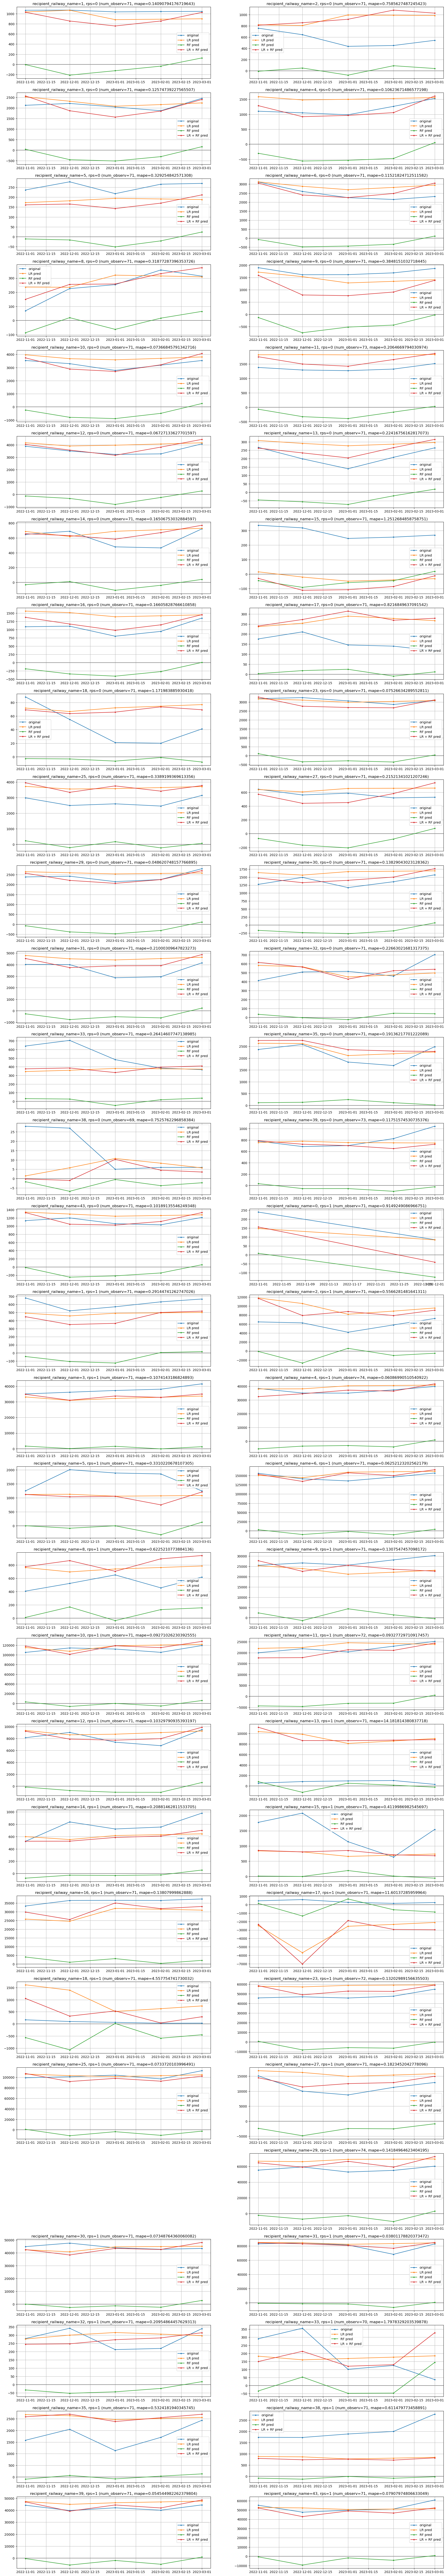

In [13]:
max_plots = len(val_data[target_granularity + ['real_wagon_count']].groupby(target_granularity[1:]))

plt.figure(figsize=(24, 150))

cols = 2
rows = max_plots // cols + 1

mape_list = list()
n = 0 

# print(models_dict, sep='\n')
for id, item in enumerate(val_data[target_granularity + ['real_wagon_count']].groupby(target_granularity[1:])):
    # groupes_queue.put(item)

    group_info, item = item
    
    item = item.groupby('period').sum()
    
    x = item.index
    y = item.real_wagon_count
    
    (lr_model, rf_model, num_observ) = models_dict.get(group_info, (None, None, None))
#     print(lr_model.coef_)
    if lr_model is not None:        
        X_val = np.array([
            [item.year for item in x],
            [item.month for item in x],
            [item.month % 4 for item in x],
        ]
        ).T

        trend_pred = lr_model.predict(X_val)

        # RF train and prediction
        X_val = np.array([
            [item.month for item in x],
            [item.month % 4 for item in x],
        ]
        ).T
        
        rf_pred = rf_model.predict(X_val)

        total_pred = trend_pred + rf_pred
        mape = mean_absolute_percentage_error(y_true=y, y_pred=total_pred)
        mape_list.append(mape)
        n += 1

        ax = plt.subplot(rows, cols, id + 1)
        plt.axhline(y=0, color="gray", linestyle="-")
        
        plt.plot(x, y, label='original', marker='.')
        plt.plot(x, trend_pred, label='LR pred', marker='.')
        plt.plot(x, rf_pred, label='RF pred', marker='.')
        plt.plot(x, trend_pred + rf_pred, label='LR + RF pred', marker='.')
        
        text_title=f'recipient_railway_name={group_info[1]}, rps={group_info[0]} ({num_observ=}, {mape=})'
        plt.title(text_title)
        plt.grid(True)
        
        plt.legend()
    else:
        print(f'{group_info=}')